
===== Decision Tree Scratch =====
Confusion Matrix:
 [[  0 143  16]
 [  0 357  38]
 [  2 219  27]]
Accuracy: 0.47880299251870323
Precision: 0.27661876062432394
Recall: 0.33755614536545525
F1: 0.26835577043759173
LogLoss: 18.785844285100957

===== Decision Tree Library =====
Confusion Matrix:
 [[  0 143  16]
 [  0 357  38]
 [  2 220  26]]
Accuracy: 0.4775561097256858
Precision: 0.2736111111111111
Recall: 0.33621205934394993
F1: 0.26629844325349084
LogLoss: 1.1281967761962264


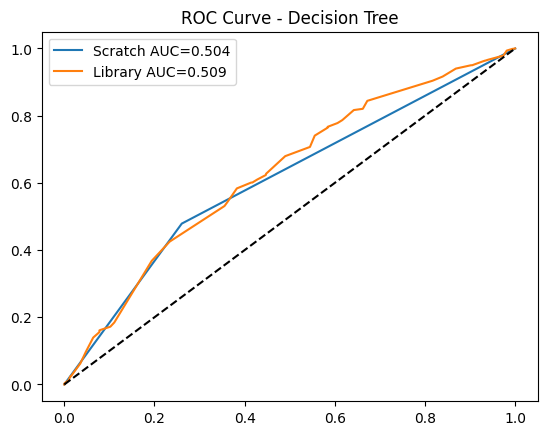

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    log_loss,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    mean_squared_error,
    r2_score,
    roc_curve,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

# =====================================================
# CONFIG
# =====================================================
WINDOW_SIZE = 14
DATA_PATH = '../CLASSIFY-SnP_daily_update_AMZN_features_with_target.csv'
FEATURE_PATH = '../CLASSIFY-AMZN_methods_all_in_one.csv'
TARGET_COL = 'Target_Return_7d'

UP_THRESHOLD = 0.03
DOWN_THRESHOLD = -0.03

CLASS_LABELS = {0: 'Downtrend', 1: 'Sideway', 2: 'Uptrend'}
classes = np.array([0, 1, 2])

# =====================================================
# 1) LOAD DATA
# =====================================================
df = pd.read_csv(DATA_PATH)
feature_df = pd.read_csv(FEATURE_PATH)

requested_features = [
    'ma_gap_20', 'vol_10', 'vol_20',
    'lower_wick', 'upper_wick',
    'ret_1', 'range_pct', 'co_ret', 'ret_5'
]

allowed_features = feature_df['feature'].tolist() if 'feature' in feature_df.columns else []
feature_cols = [c for c in requested_features if c in allowed_features and c in df.columns]

if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

model_df = df[feature_cols + [TARGET_COL]].replace([np.inf, -np.inf], np.nan).dropna()

# =====================================================
# 2) TARGET + WINDOW
# =====================================================
def map_target_3class(y):
    y_cls = np.full(y.shape, 1, dtype=np.int64)
    y_cls[y > UP_THRESHOLD] = 2
    y_cls[y < DOWN_THRESHOLD] = 0
    return y_cls

def make_windows(X, y, window=14):
    Xw, yw = [], []
    for i in range(window, len(X)):
        Xw.append(X[i-window:i].reshape(-1))
        yw.append(y[i])
    return np.array(Xw), np.array(yw)

X_raw = model_df[feature_cols].values
y_raw = map_target_3class(model_df[TARGET_COL].values)

X_win, y_win = make_windows(X_raw, y_raw, WINDOW_SIZE)

split = int(len(X_win) * 0.8)
X_train, X_test = X_win[:split], X_win[split:]
y_train, y_test = y_win[:split], y_win[split:]

# =====================================================
# 3) DECISION TREE FROM SCRATCH
# =====================================================
class DecisionTreeScratch:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    def gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return 1 - np.sum(probs**2)

    def best_split(self, X, y):
        best_gini = 1
        best_feat = None
        best_thresh = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left = y[X[:, feature] <= t]
                right = y[X[:, feature] > t]
                if len(left) == 0 or len(right) == 0:
                    continue

                g = (len(left)/len(y))*self.gini(left) + \
                    (len(right)/len(y))*self.gini(right)

                if g < best_gini:
                    best_gini = g
                    best_feat = feature
                    best_thresh = t

        return best_feat, best_thresh

    def build(self, X, y, depth=0):
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return np.bincount(y).argmax()

        feat, thresh = self.best_split(X, y)
        if feat is None:
            return np.bincount(y).argmax()

        left_idx = X[:, feat] <= thresh
        right_idx = X[:, feat] > thresh

        return {
            "feature": feat,
            "threshold": thresh,
            "left": self.build(X[left_idx], y[left_idx], depth+1),
            "right": self.build(X[right_idx], y[right_idx], depth+1)
        }

    def fit(self, X, y):
        self.tree = self.build(X, y)

    def _predict_one(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node["feature"]] <= node["threshold"]:
            return self._predict_one(x, node["left"])
        else:
            return self._predict_one(x, node["right"])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

    def predict_proba(self, X):
        preds = self.predict(X)
        proba = np.zeros((len(preds), len(classes)))
        for i, p in enumerate(preds):
            proba[i, p] = 1.0
        return proba

# Train scratch tree
tree_scratch = DecisionTreeScratch(max_depth=5)
tree_scratch.fit(X_train, y_train)
y_pred_scratch = tree_scratch.predict(X_test)
y_prob_scratch = tree_scratch.predict_proba(X_test)

# =====================================================
# 4) SKLEARN TREE
# =====================================================
tree_lib = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_lib.fit(X_train, y_train)

y_pred_lib = tree_lib.predict(X_test)
y_prob_lib = tree_lib.predict_proba(X_test)

# =====================================================
# 5) METRICS FUNCTION
# =====================================================
def evaluate(name, y_true, y_pred, y_prob):
    print(f"\n===== {name} =====")

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    print("Confusion Matrix:\n", cm)

    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, average='macro', zero_division=0))
    print("F1:", f1_score(y_true, y_pred, average='macro', zero_division=0))
    print("LogLoss:", log_loss(y_true, y_prob, labels=classes))

evaluate("Decision Tree Scratch", y_test, y_pred_scratch, y_prob_scratch)
evaluate("Decision Tree Library", y_test, y_pred_lib, y_prob_lib)

# =====================================================
# 6) ROC
# =====================================================
y_test_bin = label_binarize(y_test, classes=classes)

roc_s = roc_auc_score(y_test_bin, y_prob_scratch, average='macro', multi_class='ovr')
roc_l = roc_auc_score(y_test_bin, y_prob_lib, average='macro', multi_class='ovr')

fpr_s, tpr_s, _ = roc_curve(y_test_bin.ravel(), y_prob_scratch.ravel())
fpr_l, tpr_l, _ = roc_curve(y_test_bin.ravel(), y_prob_lib.ravel())

plt.plot(fpr_s, tpr_s, label=f'Scratch AUC={roc_s:.3f}')
plt.plot(fpr_l, tpr_l, label=f'Library AUC={roc_l:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curve - Decision Tree")
plt.show()